In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense,LSTM, Concatenate, Input,Conv1D, GlobalMaxPooling1D, Dropout,SimpleRNN, Embedding, LSTM, GRU, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer, PorterStemmer
import matplotlib.pyplot as plt
from customtkinter import *



# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert")

c:\Users\korez\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('sentiment.csv')
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [3]:
def preprocess(text):
    text = text.lower().strip() # strip lower
    text = re.sub(r'@\w+','',text) # remove mention
    text = re.sub(r'http\S+','',text) # URL
    return text.strip()

In [4]:
df['Preprocessed'] = df['Sentence'].apply(preprocess)

In [5]:
df.head()

,Sentence,Sentiment,Preprocessed
0,The GeoSolutions technology will leverage Bene...,positive,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"$esi on lows, down $1.50 to $2.50 bk a real po..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,"for the last quarter of 2010 , componenta 's n..."
3,According to the Finnish-Russian Chamber of Co...,neutral,according to the finnish-russian chamber of co...
4,The Swedish buyout firm has sold its remaining...,neutral,the swedish buyout firm has sold its remaining...


In [6]:
# Function to extract FinBERT embeddings
def extract_bert_features(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64) # 128, 256
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [7]:
df["bert_embedding"] = df["Preprocessed"].apply(extract_bert_features)

In [8]:
df['Sentiment'] = df['Sentiment'].map({
    'negative' : 0,
    'neutral' : 1,
    'positive' : 2
})

In [9]:
df.head()

,Sentence,Sentiment,Preprocessed,bert_embedding
0,The GeoSolutions technology will leverage Bene...,2,the geosolutions technology will leverage bene...,"[-0.06491287, 0.7061693, 0.12085495, -0.134157..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0,"$esi on lows, down $1.50 to $2.50 bk a real po...","[-0.3686356, -0.063531935, 0.38443413, 0.13279..."
2,"For the last quarter of 2010 , Componenta 's n...",2,"for the last quarter of 2010 , componenta 's n...","[-0.10292865, 0.09704621, 0.27700412, -0.24845..."
3,According to the Finnish-Russian Chamber of Co...,1,according to the finnish-russian chamber of co...,"[0.20317908, 0.9763274, -0.15991016, -0.220097..."
4,The Swedish buyout firm has sold its remaining...,1,the swedish buyout firm has sold its remaining...,"[0.055881064, 0.0720015, 0.035405397, -0.24500..."


In [10]:
df['Sentiment'].value_counts()

Sentiment
1    3130
2    1852
0     860
Name: count, dtype: int64

In [11]:
x = np.stack(df["bert_embedding"].values)  # (num_samples, 768)
y = df['Sentiment']

In [12]:
x.shape

(5842, 768)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [14]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Resample the dataset
x_train, y_train = smote.fit_resample(x_train, y_train)

y_train


array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [15]:
vocab_size = 5842  # Adjust based on dataset
embedding_dim = 768  # Similar to Transformer model
max_length = 128  # Max words per sentence

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)

In [16]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
]

In [17]:
# 1. Recurrent Neural Network (RNN)
rnn_model = Sequential([
    embedding_layer,
    SimpleRNN(128, activation='tanh', return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])
rnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=3e-5,clipnorm=1.0),  # Lower learning rate
    metrics=['accuracy']
)

rnn_history = rnn_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test), callbacks=callbacks)


Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.4376 - loss: 1.1081

235/235 ━━━━━━━━━━━━━━━━━━━━ 72s 300ms/step - accuracy: 0.4378 - loss: 1.1079 - val_accuracy: 0.5860 - val_loss: 0.9781 - learning_rate: 3.0000e-05
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5595 - loss: 1.0010

235/235 ━━━━━━━━━━━━━━━━━━━━ 69s 295ms/step - accuracy: 0.5595 - loss: 1.0009 - val_accuracy: 0.6014 - val_loss: 0.9208 - learning_rate: 3.0000e-05
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 71s 303ms/step - accuracy: 0.5970 - loss: 0.9535 - val_accuracy: 0.5672 - val_loss: 0.9736 - learning_rate: 3.0000e-05
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6091 - loss: 0.9285

235/235 ━━━━━━━━━━━━━━━━━━━━ 72s 307ms/step - accuracy: 0.6091 - loss: 0.9285 - val_accuracy: 0.6364 - val_loss: 0.8669 - learning_rate: 3.0000e-05
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 72s 308ms/step - accuracy: 0.6207 - loss: 0.8970 - val_accuracy: 0.6245 - val_loss: 0.9048 - learning_rate: 3.0000e-05
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 71s 302ms/step - accuracy: 0.6409 - loss: 0.8758 - val_accuracy: 0.6270 - val_loss: 0.8801 - learning_rate: 3.0000e-05
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6506 - loss: 0.8654
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
235/235 ━━━━━━━━━━━━━━━━━━━━ 71s 301ms/step - accuracy: 0.6506 - loss: 0.8654 - val_accuracy: 0.6364 - val_loss: 0.8526 - learning_rate: 3.0000e-05
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 70s 296ms/step - accuracy: 0.6666 - loss: 0.8297 - val_accuracy: 0.6210 - val_loss: 0.8898 - learning_rate: 1.5000e-05
Epoch 9/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 70s 298ms/step - accur

In [18]:
# 2. Deep Neural Network (DNN)
dnn_model = Sequential([
    embedding_layer,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])
dnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=3e-5,clipnorm=1.0),  # Lower learning rate
    metrics=['accuracy'] 
)

dnn_history = dnn_model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks)


Epoch 1/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 479s 4s/step - accuracy: 0.3794 - loss: 1.7332 - val_accuracy: 0.5672 - val_loss: 1.3390 - learning_rate: 3.0000e-05
Epoch 2/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5491 - loss: 1.2847

118/118 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step - accuracy: 0.5494 - loss: 1.2842 - val_accuracy: 0.6518 - val_loss: 1.0947 - learning_rate: 3.0000e-05
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6545 - loss: 1.0700

118/118 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.6545 - loss: 1.0698 - val_accuracy: 0.7066 - val_loss: 0.9082 - learning_rate: 3.0000e-05
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - accuracy: 0.7021 - loss: 0.9578 - val_accuracy: 0.7006 - val_loss: 0.8658 - learning_rate: 3.0000e-05
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 484s 4s/step - accuracy: 0.7123 - loss: 0.8883 - val_accuracy: 0.7066 - val_loss: 0.8426 - learning_rate: 3.0000e-05
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7294 - loss: 0.8511
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
118/118 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - accuracy: 0.7295 - loss: 0.8510 - val_accuracy: 0.6955 - val_loss: 0.8388 - learning_rate: 3.0000e-05
Epoch 7/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7416 - loss: 0.8077

118/118 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.7416 - loss: 0.8077 - val_accuracy: 0.7151 - val_loss: 0.7963 - learning_rate: 1.5000e-05
Epoch 8/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 482s 4s/step - accuracy: 0.7331 - loss: 0.8026 - val_accuracy: 0.7134 - val_loss: 0.7833 - learning_rate: 1.5000e-05
Epoch 9/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7506 - loss: 0.7750

118/118 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - accuracy: 0.7506 - loss: 0.7750 - val_accuracy: 0.7177 - val_loss: 0.7640 - learning_rate: 1.5000e-05
Epoch 10/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 482s 4s/step - accuracy: 0.7569 - loss: 0.7549 - val_accuracy: 0.7143 - val_loss: 0.7649 - learning_rate: 1.5000e-05
Epoch 11/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7667 - loss: 0.7442

118/118 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.7666 - loss: 0.7442 - val_accuracy: 0.7263 - val_loss: 0.7392 - learning_rate: 1.5000e-05
Epoch 12/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 493s 4s/step - accuracy: 0.7487 - loss: 0.7514 - val_accuracy: 0.7117 - val_loss: 0.7775 - learning_rate: 1.5000e-05
Epoch 13/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 493s 4s/step - accuracy: 0.7676 - loss: 0.7247 - val_accuracy: 0.7151 - val_loss: 0.7536 - learning_rate: 1.5000e-05
Epoch 14/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7595 - loss: 0.7228
Epoch 14: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-06.
118/118 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - accuracy: 0.7595 - loss: 0.7228 - val_accuracy: 0.7117 - val_loss: 0.7406 - learning_rate: 1.5000e-05
Epoch 15/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.7663 - loss: 0.7047 - val_accuracy: 0.7083 - val_loss: 0.7548 - learning_rate: 7.5000e-06
Epoch 16/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.764

In [19]:
# # 3. Recursive Neural Network (RecNN) (Using LSTM to mimic tree-like structure)
# recnn_model = Sequential([
#     embedding_layer,
#     LSTM(128, return_sequences=True),
#     LSTM(64, return_sequences=False),
#     Dropout(0.4),
#     Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
#     Dropout(0.4),
#     Dense(3, activation='softmax')
# ])
# recnn_model.compile(
#     loss='categorical_crossentropy',
#     optimizer=Adam(learning_rate=3e-5),  # Lower learning rate
#     metrics=['accuracy']
# )

# recnn_history = recnn_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test), callbacks=callbacks)


In [20]:
# 4. Hybrid Neural Network (HNN) (Combining LSTM and GRU)
hnn_model = Sequential([
    embedding_layer,
    LSTM(128, return_sequences=True),
    GRU(64, return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])
hnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=3e-5,clipnorm=1.0),  # Lower learning rate
    metrics=['accuracy']
)

hnn_history = hnn_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 192s 805ms/step - accuracy: 0.3438 - loss: 1.1292 - val_accuracy: 0.3216 - val_loss: 1.1275 - learning_rate: 3.0000e-05
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 189s 804ms/step - accuracy: 0.3820 - loss: 1.1140 - val_accuracy: 0.5295 - val_loss: 0.9527 - learning_rate: 3.0000e-05
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 191s 812ms/step - accuracy: 0.4671 - loss: 1.0604 - val_accuracy: 0.5201 - val_loss: 1.0662 - learning_rate: 3.0000e-05
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 191s 811ms/step - accuracy: 0.4857 - loss: 1.0458 - val_accuracy: 0.5381 - val_loss: 0.9434 - learning_rate: 3.0000e-05
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 191s 815ms/step - accuracy: 0.4516 - loss: 1.0547 - val_accuracy: 0.5261 - val_loss: 1.0157 - learning_rate: 3.0000e-05
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 191s 812ms/step - accuracy: 0.4720 - loss: 1.0599 - val_accuracy: 0.5227 - val_loss: 1.0590 - learning_rate: 3.0000e-05
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 

In [21]:
lstm_model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(768, 1)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=3e-5),  # Lower learning rate
    metrics=['accuracy']
)

# Reshape for LSTM
X_train_lstm = np.expand_dims(x_train, axis=-1)
X_test_lstm = np.expand_dims(x_test, axis=-1)

lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=25, batch_size=64, validation_data=(X_test_lstm, y_test),callbacks=callbacks)

Epoch 1/25


c:\Users\korez\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 669ms/step - accuracy: 0.3739 - loss: 1.1390 - val_accuracy: 0.6082 - val_loss: 1.1250 - learning_rate: 3.0000e-05
Epoch 2/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 648ms/step - accuracy: 0.4830 - loss: 1.1316 - val_accuracy: 0.6253 - val_loss: 1.1096 - learning_rate: 3.0000e-05
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 645ms/step - accuracy: 0.5201 - loss: 1.1183 - val_accuracy: 0.6433 - val_loss: 1.0725 - learning_rate: 3.0000e-05
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 77s 656ms/step - accuracy: 0.5144 - loss: 1.0885 - val_accuracy: 0.5269 - val_loss: 0.9837 - learning_rate: 3.0000e-05
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 78s 662ms/step - accuracy: 0.6074 - loss: 0.9397 - val_accuracy: 0.5689 - val_loss: 0.9424 - learning_rate: 3.0000e-05
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.6563 - loss: 0.8463
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
118/118 ━━━━━━━━━━━━━━━━━━━━ 77s 654ms/step - accur

In [22]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train.ravel())
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [23]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dense = Dense(embed_dim, activation="relu", kernel_regularizer=l2(0.001))
        self.dropout1 = Dropout(dropout_rate)  # Dropout after attention
        self.dropout2 = Dropout(dropout_rate)  # Dropout after dense

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)  # Apply dropout
        out1 = self.norm1(inputs + attn_output)

        dense_output = self.dense(out1)
        dense_output = self.dropout2(dense_output, training=training)  # Apply dropout
        return self.norm2(out1 + dense_output)

transformer_model = Sequential([
    TransformerBlock(embed_dim=768, num_heads=12,dropout_rate=0.7),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu',kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

transformer_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=3e-5,clipnorm=1.0),  # Lower learning rate
    metrics=['accuracy']
)

# Reshape for Transformer
X_train_transformer = np.expand_dims(x_train, axis=1)  # (batch_size, seq_len, embedding_dim)
X_test_transformer = np.expand_dims(x_test, axis=1)

transformer_history = transformer_model.fit(X_train_transformer, y_train, epochs=25, batch_size=32, validation_data=(X_test_transformer, y_test),class_weight=class_weight_dict, callbacks=callbacks)

Epoch 1/25



235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6026 - loss: 1.9039

235/235 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.6029 - loss: 1.9030 - val_accuracy: 0.7930 - val_loss: 1.3797 - learning_rate: 3.0000e-05
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7453 - loss: 1.5019

235/235 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.7453 - loss: 1.5018 - val_accuracy: 0.7973 - val_loss: 1.3268 - learning_rate: 3.0000e-05
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7673 - loss: 1.4308

235/235 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.7673 - loss: 1.4307 - val_accuracy: 0.8041 - val_loss: 1.3573 - learning_rate: 3.0000e-05
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7797 - loss: 1.3975

235/235 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.7797 - loss: 1.3974 - val_accuracy: 0.8050 - val_loss: 1.3551 - learning_rate: 3.0000e-05
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.7815 - loss: 1.3851 - val_accuracy: 0.7904 - val_loss: 1.3313 - learning_rate: 3.0000e-05
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.8041 - loss: 1.3171 - val_accuracy: 0.7921 - val_loss: 1.3295 - learning_rate: 3.0000e-05
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8187 - loss: 1.3162
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
235/235 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.8186 - loss: 1.3162 - val_accuracy: 0.8007 - val_loss: 1.3420 - learning_rate: 3.0000e-05
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.7987 - loss: 1.3147 - val_accuracy: 0.8015 - val_loss: 1.3329 - learning_rate: 1.5000e-05
Epoch 9/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.8124 - l

In [24]:
# from tensorflow.keras.layers import Input, Concatenate, Dense
# from tensorflow.keras.models import Model

# # Get inputs & outputs from LSTM model
# lstm_input = lstm_model.input
# lstm_output = lstm_model.output

# # Get inputs & outputs from Transformer model
# transformer_input = transformer_model.input
# transformer_output = transformer_model.output

# # Concatenate outputs
# fusion = Concatenate()([lstm_output, transformer_output])

# # Add a Dense layer for final classification
# final_output = Dense(3, activation='softmax')(fusion)  # 3 classes

# # Define the ensemble model
# ensemble_model = Model(inputs=[lstm_input, transformer_input], outputs=final_output)

# # Compile the model
# ensemble_model.compile(
#     optimizer=Adam(learning_rate=3e-5,clipnorm=1.0), 
#     loss='categorical_crossentropy',  # Change this if labels are integers
#     metrics=['accuracy']
# )

# fusion_history = ensemble_model.fit(
#     [X_train_lstm, X_train_transformer], y_train, 
#     validation_data=([X_test_lstm, X_test_transformer], y_test),  # Use correct validation set
#     epochs=25,
#     batch_size=32
# )

In [25]:
def graph(hist):
    # Extract accuracy and loss values
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.show()


In [26]:
def fetch_edf(model):
    # Get model predictions
    y_pred_probs = transformer_model.predict(X_test_transformer)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Find misclassified samples
    misclassified_indices = np.where(y_pred != y_true)[0]

    # Create a DataFrame of errors
    error_analysis_df = pd.DataFrame({
        "Actual": y_true[misclassified_indices],
        "Predicted": y_pred[misclassified_indices],
        "Comment": df['Sentence'][misclassified_indices]
    })

In [27]:
lstm_acc = lstm_model.evaluate(X_test_lstm, y_test)[1]
transformer_acc = transformer_model.evaluate(X_test_transformer, y_test)[1]
deep_acc = dnn_model.evaluate(x_test,y_test)[1]
recurrent_acc = rnn_model.evaluate(x_test,y_test)[1]
# recnn_acc = recnn_model.evaluate(x_test,y_test)[1]
hnn_acc = hnn_model.evaluate(x_test,y_test)[1]

print(f"LSTM Accuracy: {lstm_acc:.4f}")
print(f"Transformer Accuracy: {transformer_acc:.4f}")
print(f"Deep NN Accuracy: {deep_acc:.4f}")
print(f"Recurrent NN Accuracy: {recurrent_acc:.4f}")
# print(f"Recursive NN Accuracy: {recnn_acc:.4f}")
print(f"Hybrid NN Accuracy: {hnn_acc:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.6419 - loss: 1.0711
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8025 - loss: 1.3491
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - accuracy: 0.7208 - loss: 0.7394
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5562 - loss: 0.9622
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.5414 - loss: 0.9401
LSTM Accuracy: 0.6433
Transformer Accuracy: 0.8050
Deep NN Accuracy: 0.7220
Recurrent NN Accuracy: 0.5577
Hybrid NN Accuracy: 0.5432


In [29]:
# error_analysis_df[['Actual','Predicted']].value_counts()

In [64]:
# error_analysis_df.shape

(238, 3)

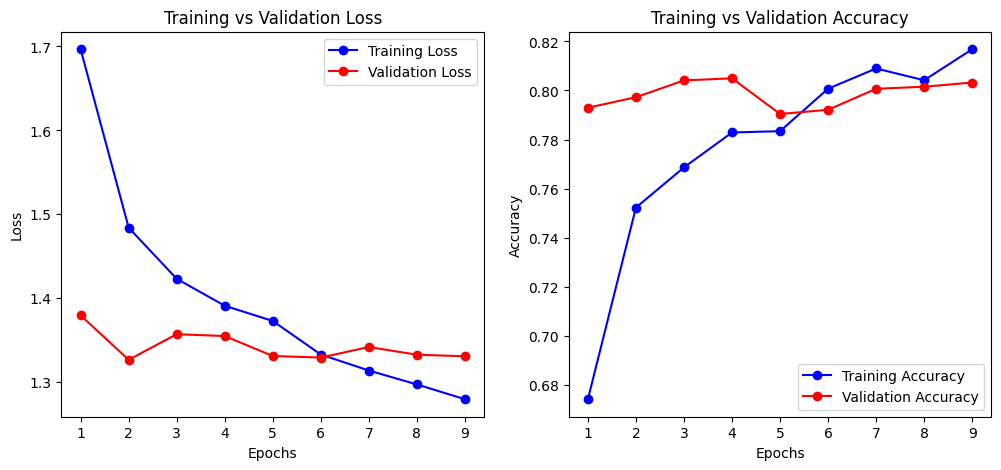

In [30]:
graph(transformer_history)

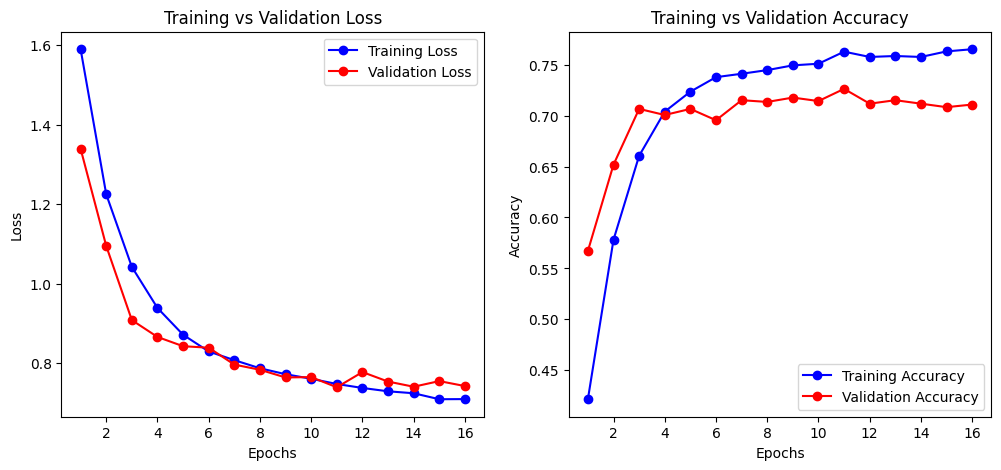

In [31]:
graph(dnn_history)

In [32]:
def multigraph(histories, model_names):
    plt.figure(figsize=(23, 12))

    # Loss Plot
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history.get('loss', []), label=f'{name} Train Loss')
        plt.plot(history.history.get('val_loss', []), label=f'{name} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history.get('accuracy', []), label=f'{name} Train Acc')
        plt.plot(history.history.get('val_accuracy', []), label=f'{name} Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.show()

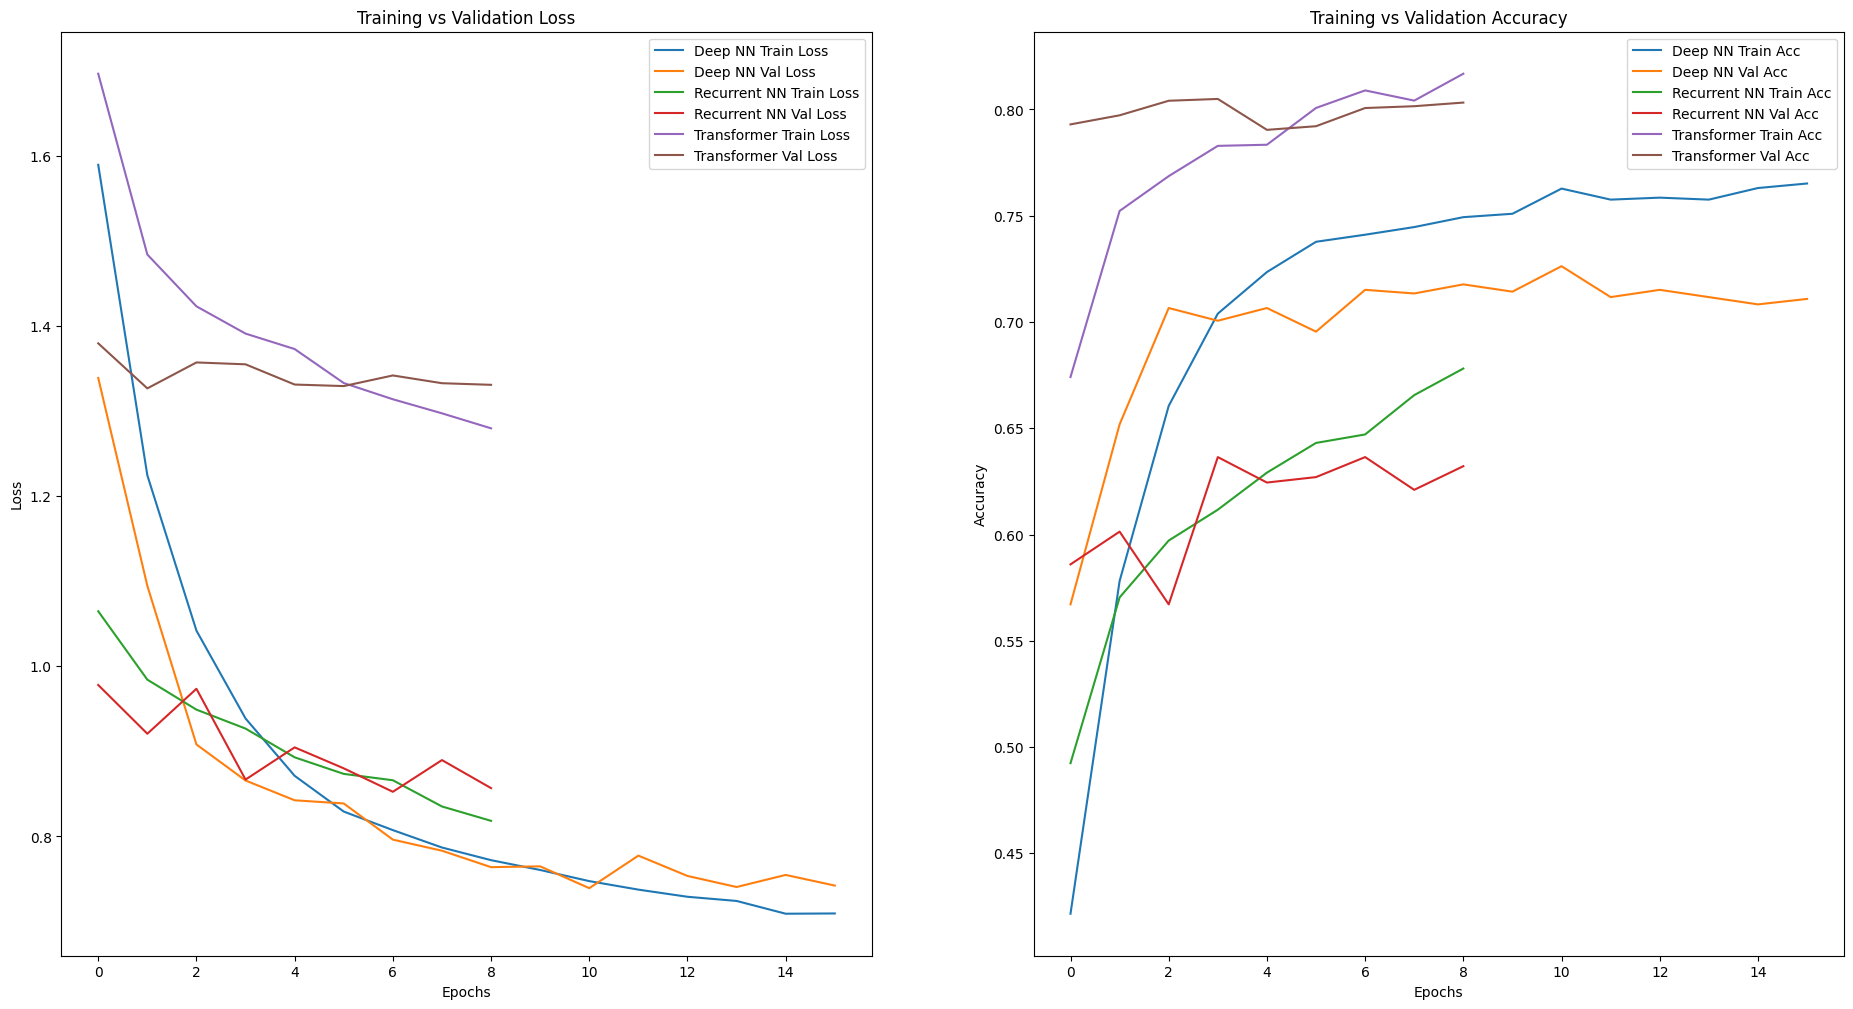

In [33]:
multigraph([dnn_history,rnn_history,transformer_history],['Deep NN','Recurrent NN','Transformer'])